# Clustering y análisis no supervisado

En este notebook exploraremos:

- Preparación de datos para clustering:
  - Estandarización y otros *scalers*
  - Reducción de dimensionalidad (PCA) para visualización
- Diferentes algoritmos de clustering:
  - K-Means
  - Gaussian Mixture Models (GMM)
  - Clustering jerárquico (Agglomerative)
  - DBSCAN (density-based)
- Elección de hiperparámetros:
  - Número de clusters (k)
  - Parámetros de DBSCAN (`eps`, `min_samples`)
- Métricas de evaluación:
  - Internas: Silhouette, Calinski-Harabasz, Davies-Bouldin
  - Externas (cuando conocemos las etiquetas verdaderas): ARI, NMI
- Visualización y comparación de resultados.

Este notebook tiene un propósito educativo: entender el comportamiento de diferentes algoritmos de clustering y las decisiones prácticas más importantes.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs, make_moons, make_circles, load_iris
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score
)

from scipy.cluster.hierarchy import dendrogram, linkage

np.random.seed(42)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 5)

- Funciones auxiliares

In [16]:
def evaluate_clustering(X, labels, y_true=None, name="Modelo"):
    print(f"=== {name} ===")
    print(f"Silhouette: {silhouette_score(X, labels):.3f}")
    print(f"Calinski-Harabasz: {calinski_harabasz_score(X, labels):.3f}")
    print(f"Davies-Bouldin: {davies_bouldin_score(X, labels):.3f}")
    if y_true is not None:
        print(f"ARI: {adjusted_rand_score(y_true, labels):.3f}")
        print(f"NMI: {normalized_mutual_info_score(y_true, labels):.3f}")
    print()


In [3]:
def plot_2d_clusters(X, labels, title=None):
    """
    Scatter 2D coloreado por labels (clusters).
    """
    plt.figure()
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="tab10", s=15, alpha=0.8)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_silhouette_scores(k_list, scores, title="Silhouette vs k"):
    plt.figure()
    plt.plot(k_list, scores, marker="o")
    plt.xlabel("Número de clusters (k)")
    plt.ylabel("Silhouette score")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


- Generación de datasets sintéticos y reales

In [4]:
# 1) Blobs (clusters bien separados, caso "fácil")
X_blobs, y_blobs_true = make_blobs(
    n_samples=1000,
    centers=4,
    cluster_std=1.0,
    random_state=42
)

# 2) Moons (estructura no lineal)
X_moons, y_moons_true = make_moons(
    n_samples=1000,
    noise=0.08,
    random_state=42
)

# 3) Círculos concéntricos
X_circles, y_circles_true = make_circles(
    n_samples=1000,
    factor=0.5,
    noise=0.06,
    random_state=42
)

# 4) Iris (dataset real, sin usar las labels para entrenar)
iris = load_iris()
X_iris = iris.data
y_iris_true = iris.target
feature_names_iris = iris.feature_names


- Exploración rápida de los datasets

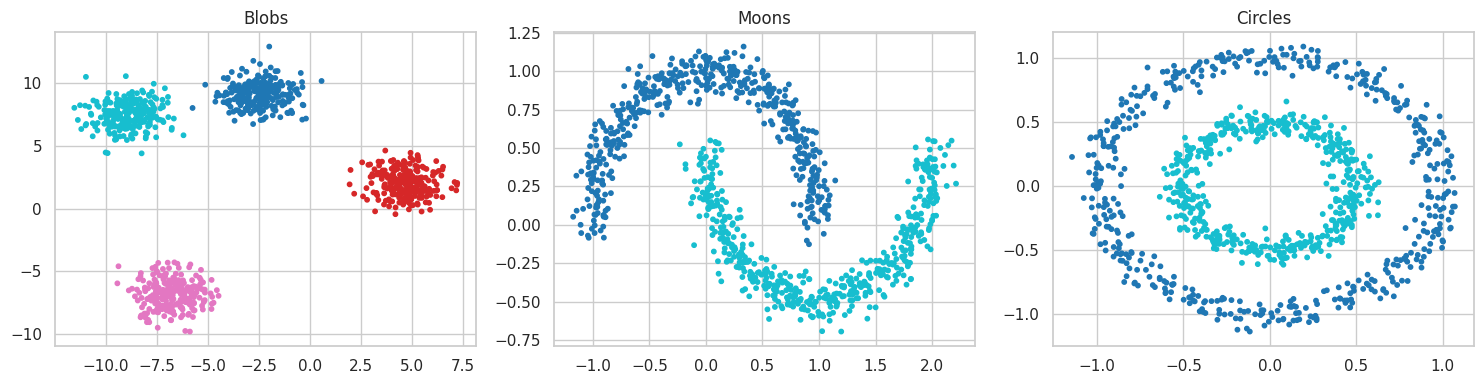

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c=y_blobs_true, cmap="tab10", s=10)
axes[0].set_title("Blobs")

axes[1].scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons_true, cmap="tab10", s=10)
axes[1].set_title("Moons")

axes[2].scatter(X_circles[:, 0], X_circles[:, 1], c=y_circles_true, cmap="tab10", s=10)
axes[2].set_title("Circles")

plt.tight_layout()
plt.show()


## 1. Escalado de variables y su efecto en el clustering

El clustering se ve muy afectado por la escala de las variables:

- **StandardScaler**: medias 0, varianza 1 (útil en general).
- **MinMaxScaler**: escala al rango [0, 1].
- **RobustScaler**: robusto a outliers (usa mediana y IQR).

Usaremos `StandardScaler` como *default*, pero mostraremos el efecto.


- Comparando scalers en K-Means

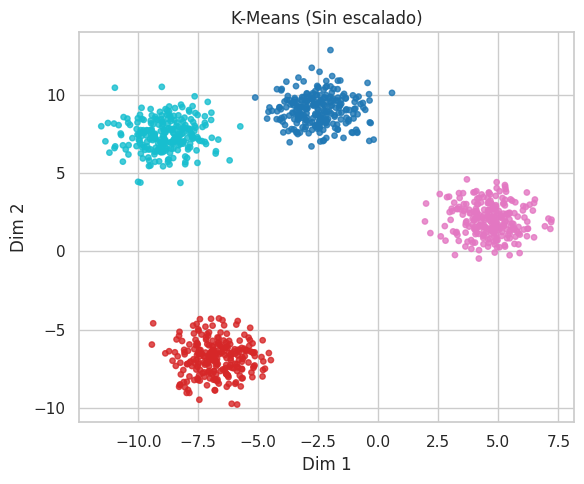

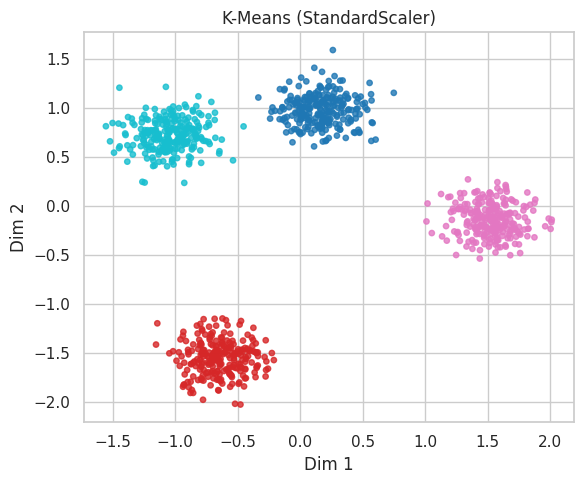

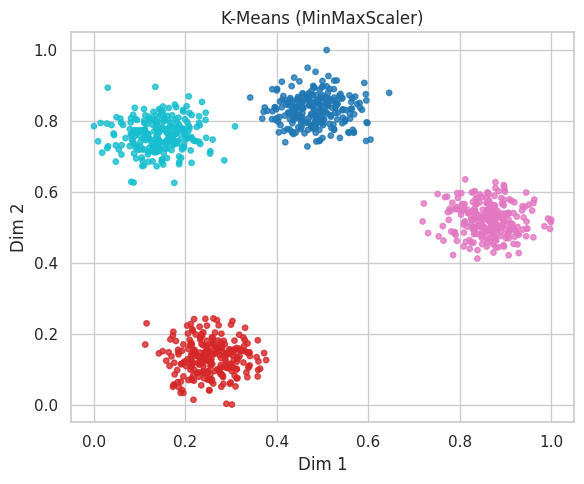

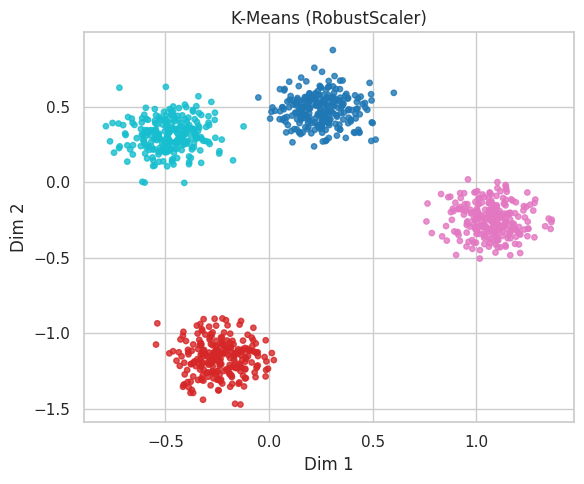

In [10]:
scalers = {
    "Sin escalado": None,
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

X_example = X_blobs  # Podrías cambiar a otros datasets

for name, scaler in scalers.items():
    if scaler is not None:
        X_scaled = scaler.fit_transform(X_example)
    else:
        X_scaled = X_example.copy()
    
    kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X_scaled)
    
    # Si escalamos, para visualizar volvemos a PCA 2D:
    if X_scaled.shape[1] > 2:
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X_scaled)
    else:
        X_vis = X_scaled
    
    plot_2d_clusters(X_vis, labels, title=f"K-Means ({name})")


## 2. K-Means clustering

K-Means intenta:

- Asignar cada punto al cluster con centroide más cercano.
- Minimizar la suma de distancias cuadráticas a los centroides.

### Elección de k:
- **Método del codo** (inertia).
- **Silhouette score** (calidad de la separación).


- K-Means: inertia y silhouette

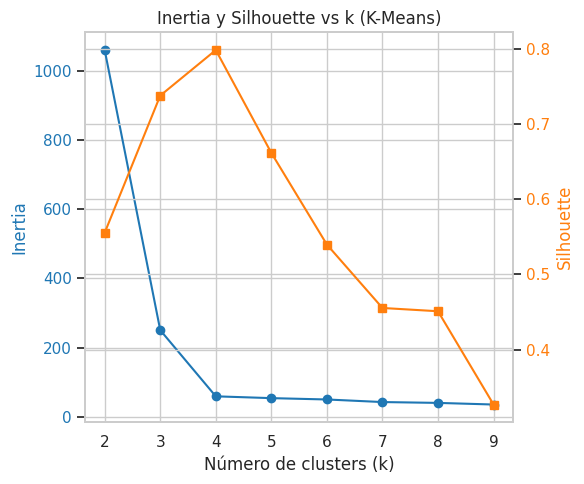

In [11]:
X = StandardScaler().fit_transform(X_blobs)

inertias = []
silhouettes = []
k_values = range(2, 10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = kmeans.fit_predict(X)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X, labels))

fig, ax1 = plt.subplots()

color1 = "tab:blue"
ax1.set_xlabel("Número de clusters (k)")
ax1.set_ylabel("Inertia", color=color1)
ax1.plot(k_values, inertias, marker="o", color=color1)
ax1.tick_params(axis="y", labelcolor=color1)

ax2 = ax1.twinx()
color2 = "tab:orange"
ax2.set_ylabel("Silhouette", color=color2)
ax2.plot(k_values, silhouettes, marker="s", color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

plt.title("Inertia y Silhouette vs k (K-Means)")
fig.tight_layout()
plt.show()


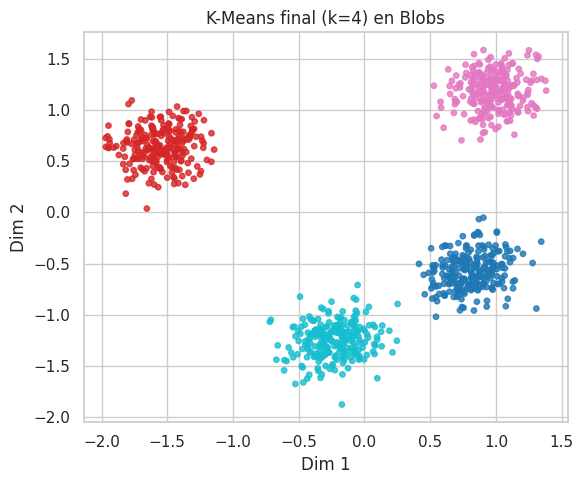

In [12]:
best_k = 4  # por inspección visual de las curvas
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
labels_kmeans = kmeans_final.fit_predict(X)

plot_2d_clusters(PCA(n_components=2).fit_transform(X), labels_kmeans, 
                 title=f"K-Means final (k={best_k}) en Blobs")


## 3. Gaussian Mixture Models (GMM)

GMM asume que los datos provienen de una mezcla de distribuciones gaussianas.

- Permite **clusters elípticos** (K-Means tiende a clusters esféricos).
- Permite **asignación "suave"** (probabilidades de pertenencia).
- Usa típicamente EM (Expectation-Maximization).

Probaremos GMM sobre el dataset de `blobs`.


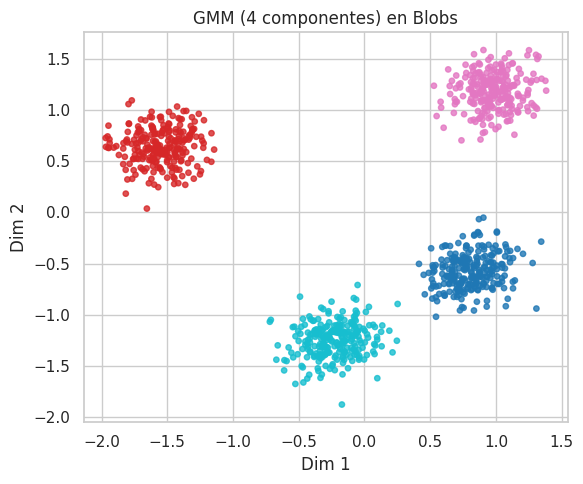

In [13]:
X = StandardScaler().fit_transform(X_blobs)

gmm = GaussianMixture(n_components=4, covariance_type="full", random_state=42)
gmm_labels = gmm.fit_predict(X)

plot_2d_clusters(PCA(n_components=2).fit_transform(X), gmm_labels, 
                 title="GMM (4 componentes) en Blobs")


## 4. Clustering jerárquico (Agglomerative)

Construye una jerarquía de clusters, fusionando iterativamente los más cercanos.

- Diferentes *linkages*: `ward`, `complete`, `average`, `single`.
- Puede visualizarse con **dendrogramas**.


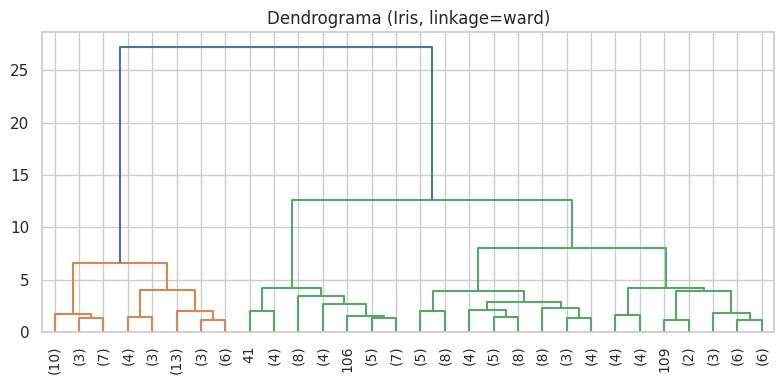

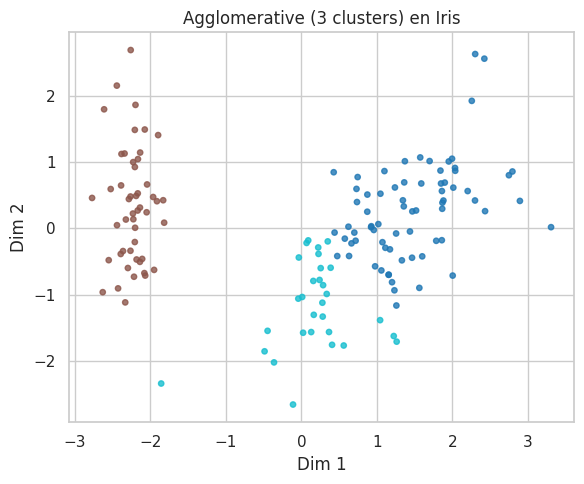

In [14]:
X = StandardScaler().fit_transform(X_iris)

# Dendrograma (usando linkage de scipy)
Z = linkage(X, method="ward")

plt.figure(figsize=(8, 4))
dendrogram(Z, truncate_mode="lastp", p=30, leaf_rotation=90.)
plt.title("Dendrograma (Iris, linkage=ward)")
plt.tight_layout()
plt.show()

# Clustering Agglomerative
agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_agg = agg.fit_predict(X)

plot_2d_clusters(PCA(n_components=2).fit_transform(X), labels_agg,
                 title="Agglomerative (3 clusters) en Iris")


## 5. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN define clusters como regiones densas en el espacio:

- No requiere especificar k.
- Detecta outliers (etiquetados como -1).
- Funciona muy bien en estructuras no lineales (ej: `moons`, `circles`).

Hiperparámetros clave:
- `eps`: radio de vecindad.
- `min_samples`: mínimo de puntos para formar una región densa.


eps=0.1: clusters encontrados = 7


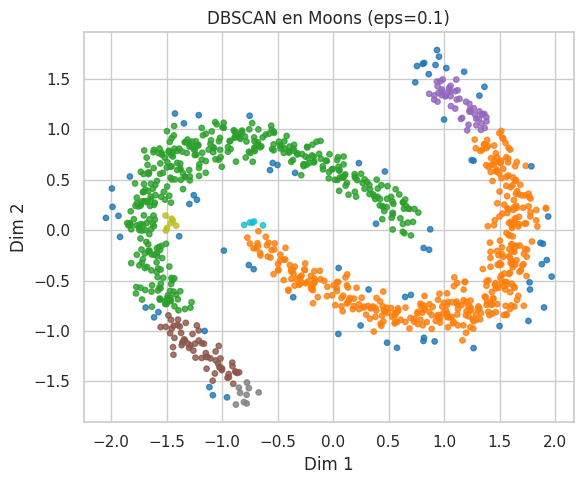

eps=0.2: clusters encontrados = 2


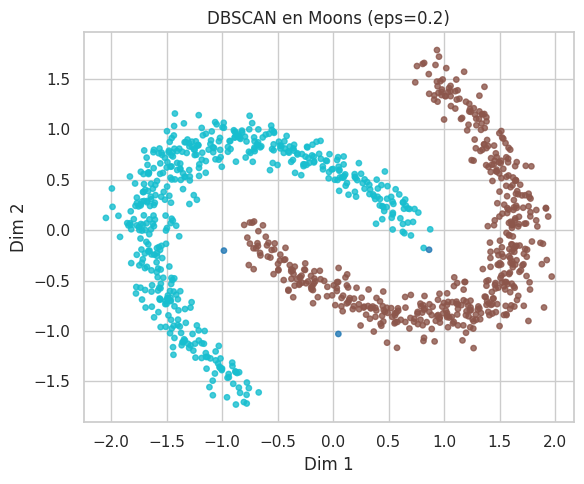

eps=0.3: clusters encontrados = 2


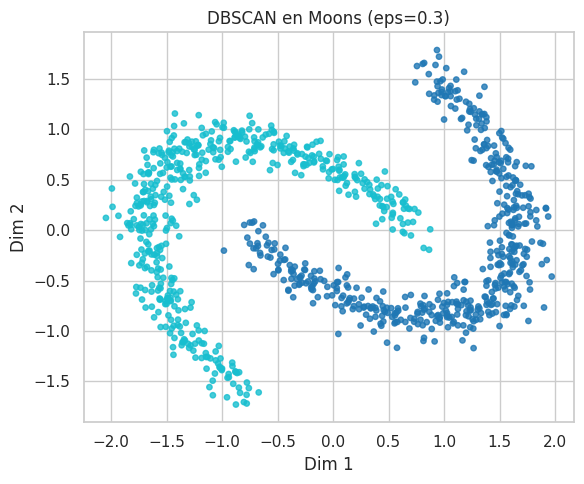

In [15]:
X = StandardScaler().fit_transform(X_moons)

for eps in [0.1, 0.2, 0.3]:
    db = DBSCAN(eps=eps, min_samples=5)
    labels_db = db.fit_predict(X)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    print(f"eps={eps}: clusters encontrados = {n_clusters}")
    plot_2d_clusters(PCA(n_components=2).fit_transform(X), labels_db,
                     title=f"DBSCAN en Moons (eps={eps})")


## 6. Métricas de evaluación en clustering

### Métricas internas (no requieren labels verdaderas)
- **Silhouette score**: qué tan bien separados están los clusters (−1 a 1).
- **Calinski-Harabasz**: varianza entre/max varianza dentro.
- **Davies-Bouldin**: más bajo es mejor.

### Métricas externas (requieren labels de referencia)
- **ARI (Adjusted Rand Index)**: comparación entre particiones, corrige por azar.
- **NMI (Normalized Mutual Information)**: información mutua normalizada.

Usaremos los datasets sintéticos que sí tienen etiquetas verdaderas para ilustrar ambas vistas.


In [17]:
X = StandardScaler().fit_transform(X_circles)
y_true = y_circles_true

# K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X)
evaluate_clustering(X, labels_km, y_true, name="K-Means")

# GMM
gmm = GaussianMixture(n_components=2, random_state=42)
labels_gmm = gmm.fit_predict(X)
evaluate_clustering(X, labels_gmm, y_true, name="GMM")

# DBSCAN
db = DBSCAN(eps=0.2, min_samples=5)
labels_db = db.fit_predict(X)
evaluate_clustering(X, labels_db, y_true, name="DBSCAN")


=== K-Means ===
Silhouette: 0.354
Calinski-Harabasz: 573.568
Davies-Bouldin: 1.186
ARI: -0.001
NMI: 0.000

=== GMM ===
Silhouette: 0.354
Calinski-Harabasz: 573.385
Davies-Bouldin: 1.185
ARI: -0.001
NMI: 0.000

=== DBSCAN ===
Silhouette: 0.111
Calinski-Harabasz: 0.002
Davies-Bouldin: 743.637
ARI: 1.000
NMI: 1.000



## 7. Búsqueda de hiperparámetros en clustering

A diferencia de los modelos supervisados, en clustering no tenemos una métrica "target" clara.  
Sin embargo, podemos:

- Definir una métrica interna (ej: Silhouette).
- Barrer hiperparámetros (k en K-Means, eps en DBSCAN).
- Elegir el conjunto que maximice la métrica.

Haremos un ejemplo sencillo con:
- K-Means: búsqueda de k.
- DBSCAN: búsqueda de eps.


- Búsqueda de k óptimo vía Silhouette

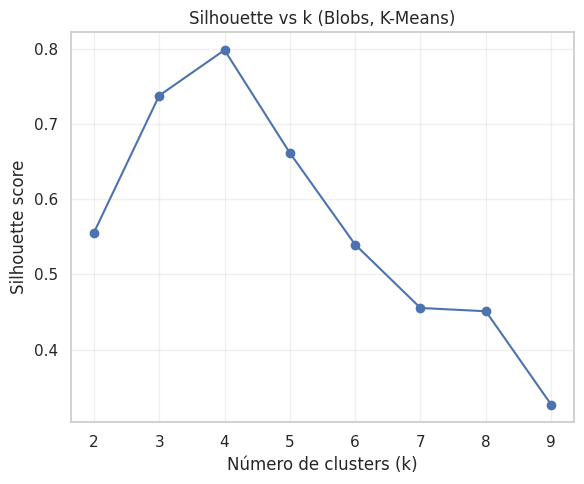

Mejor k según Silhouette: 4


In [18]:
X = StandardScaler().fit_transform(X_blobs)

k_list = range(2, 10)
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X)
    sil = silhouette_score(X, labels)
    sil_scores.append(sil)

plot_silhouette_scores(k_list, sil_scores, title="Silhouette vs k (Blobs, K-Means)")
best_k = k_list[int(np.argmax(sil_scores))]
print("Mejor k según Silhouette:", best_k)


- Búsqueda simple de eps para DBSCAN

In [19]:
X = StandardScaler().fit_transform(X_moons)

eps_values = np.linspace(0.1, 0.4, 7)
results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(X)
    # Ignoramos casos con 1 cluster o todos ruido
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters <= 1:
        sil = np.nan
    else:
        sil = silhouette_score(X, labels)
    results.append((eps, n_clusters, sil))

df_results = pd.DataFrame(results, columns=["eps", "n_clusters", "silhouette"])
df_results


,eps,n_clusters,silhouette
0,0.10,7,-0.072941
1,0.15,2,0.241380
2,0.20,2,0.145887
3,0.25,2,0.385298
4,0.30,2,0.385298
5,0.35,2,0.385298
6,0.40,1,NaN


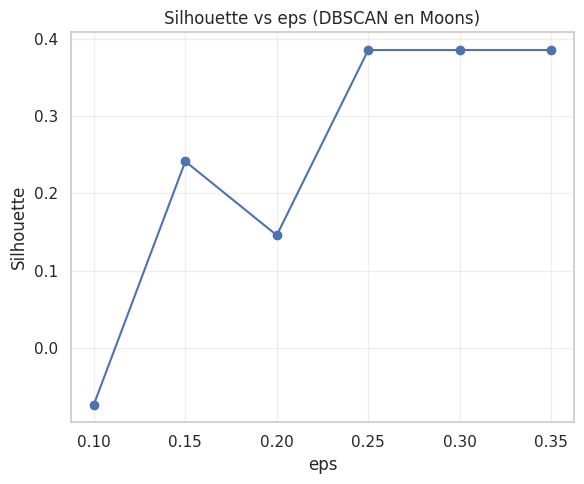

In [20]:
plt.figure()
mask = ~df_results["silhouette"].isna()
plt.plot(df_results["eps"][mask], df_results["silhouette"][mask], marker="o")
plt.xlabel("eps")
plt.ylabel("Silhouette")
plt.title("Silhouette vs eps (DBSCAN en Moons)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Clustering + reducción de dimensionalidad

En datasets de alta dimensión:

- Aplicar PCA (u otros métodos) antes de clustering:
  - Reduce ruido
  - Facilita visualización
  - Puede mejorar resultados y tiempo de cómputo

Ejemplo: Iris → PCA 2D → luego K-Means y Agglomerative.


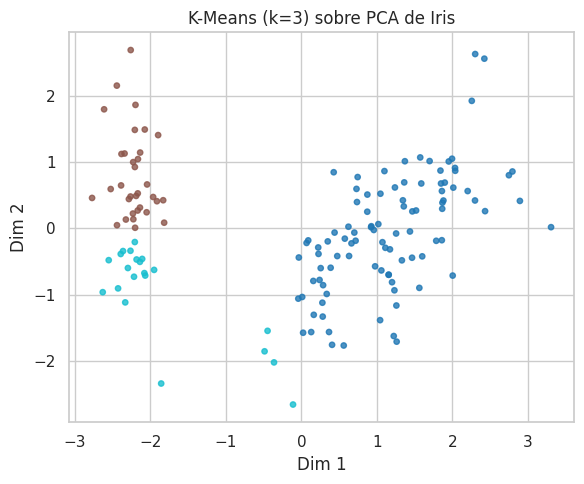

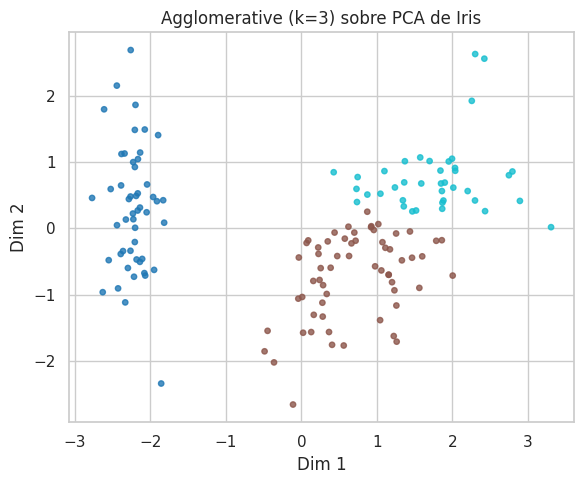

In [21]:
X = StandardScaler().fit_transform(X_iris)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto")
labels_km = kmeans.fit_predict(X_pca)

agg = AgglomerativeClustering(n_clusters=3, linkage="ward")
labels_agg = agg.fit_predict(X_pca)

plot_2d_clusters(X_pca, labels_km, title="K-Means (k=3) sobre PCA de Iris")
plot_2d_clusters(X_pca, labels_agg, title="Agglomerative (k=3) sobre PCA de Iris")


# 9. Conclusiones

En este notebook hemos:

- Explorando el efecto del escalado sobre el clustering.
- Aplicado varios algoritmos:
  - K-Means (prototipos)
  - GMM (mezcla de gaussianas)
  - Agglomerative (jerárquico)
  - DBSCAN (basado en densidad)
- Estudiado cómo:
  - Elegir k (K-Means) con inertia y silhouette.
  - Ajustar parámetros de DBSCAN (eps, min_samples).
- Usado métricas internas (Silhouette, CH, DB) y externas (ARI, NMI).
- Integrado reducción de dimensionalidad (PCA) para visualización y clustering.

Este flujo es un buen punto de partida para análisis no supervisado en datasets reales.
